<a href="https://colab.research.google.com/github/annvorosh/GB/blob/Alg_AD/Alg_AD_L5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Урок 5. Случайный лес

## Домашнее задание

1. Сформировать с помощью sklearn.make_classification датасет из 100 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50 деревьев и визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote).

In [ ]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

from sklearn.model_selection import train_test_split

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
# сгенерируем данные
classification_data, classification_labels = datasets.make_classification(n_samples=2000,
                                                      n_features = 2, n_informative = 2,
                                                      n_classes = 2, n_redundant=0,
                                                      n_clusters_per_class=1, random_state=23)

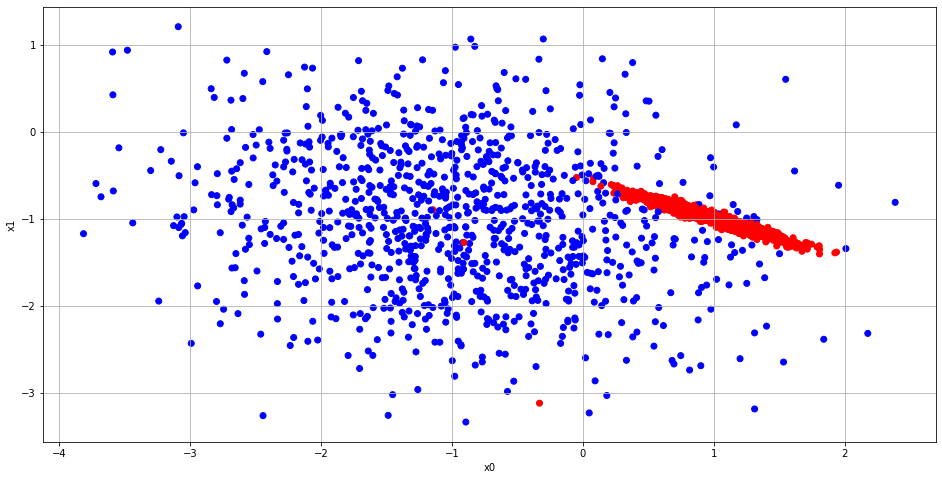

In [ ]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(16,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)),
              c=classification_labels, cmap=colors)
plt.grid()
plt.xlabel('x0')
plt.ylabel('x1')
plt.show()

Реализуем генерацию $N$ бутстрап-выборок и подмножества признаков для нахождения разбиения в узле.

In [ ]:
random.seed(42)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []

    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)

        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
        bootstrap.append((b_data, b_labels))

    return bootstrap

In [ ]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = [i for i in range(len_sample)]

    len_subsample = int(np.sqrt(len_sample))
    subsample = []

    random.shuffle(sample_indexes)
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())

    return subsample

Далее повторим реализацию построения дерева решений из предыдущего урока с некоторыми изменениями

In [ ]:
# Реализуем класс узла

class Node:

    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [ ]:
# И класс терминального узла (листа)

class Leaf:

    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()

    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его
        prediction = max(classes, key=classes.get)
        return prediction

In [ ]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1

    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2

    return impurity

In [ ]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])

    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [ ]:
# Разбиение датасета в узле

def split(data, labels, index, t):

    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)

    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]

    return true_data, false_data, true_labels, false_labels

In [ ]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):

    #  обозначим минимальное количество объектов в узле
    min_leaf = 1

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None

    # берем все признаки и делаем bootstrap
    n_features = data.shape[1]

    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)

    for index in subsample:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])

        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue

            current_quality = quality(true_labels, false_labels, current_gini)

            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [ ]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

Теперь добавим функцию формирования случайного леса.

In [ ]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)

    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))

    return forest

In [ ]:
# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [ ]:
# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):

    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [ ]:
# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))

    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))

    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))

    return voted_predictions

Далее мы сделаем обычное разбиение выборки на обучающую и тестовую, как это делалось ранее. Оценить ошибку этого же алгоритма по методу Out-of-Bag будет вашим домашним заданием к этому уроку.

In [ ]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data,
                                                                                     classification_labels,
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [ ]:
# Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0


Теперь построим несколько случайных лесов с разным количеством деревьев в них.

In [ ]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    xx,yy = np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))
    x = xx.reshape(-1,1)
    y = yy.reshape(-1,1)
    f = np.ones((x.shape[0],data[:, 2:].shape[1]))
    # print(f.shape,x.shape,y.shape)
    data_gr = np.concatenate((x,y,f),axis=1)
    return xx,yy , data_gr# список массивов координатных сеток

def plot_forest(my_forest, train_data, train_labels, train_accuracy, test_accuracy):

    plt.figure(figsize = (16, 8))

# график обучающей выборки
    plt.subplot(1,2,1)
    xx, yy, gr = get_meshgrid(train_data)
    mesh_predictions = np.array(tree_vote(my_forest, gr)).reshape(xx.shape) # определяем цвета квадратов в сетке
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy={train_accuracy:.2f}    N_trees = {len(my_forest)}')

# график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy={test_accuracy:.2f}    N_trees = {len(my_forest)}')

In [ ]:
def forest(train_data, train_labels, n_trees):

    my_forest = random_forest(train_data, train_labels, n_trees)
    # Получим ответы для обучающей выборки
    train_answers = tree_vote(my_forest, train_data)
    # И получим ответы для тестовой выборки
    test_answers = tree_vote(my_forest, test_data)
    # Точность на обучающей выборке
    train_accuracy = accuracy_metric(train_labels, train_answers)
    # Точность на тестовой выборке
    test_accuracy = accuracy_metric(test_labels, test_answers)
    plot_forest(my_forest, train_data, train_labels, train_accuracy, test_accuracy)

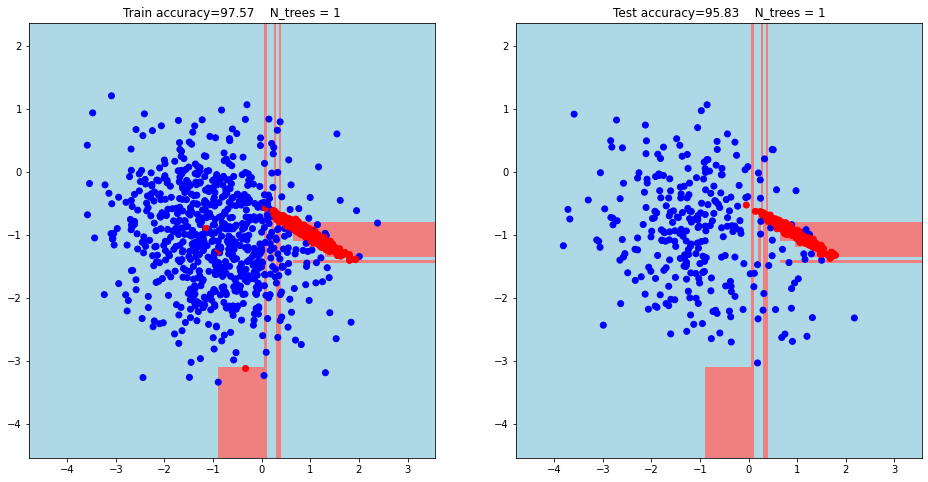

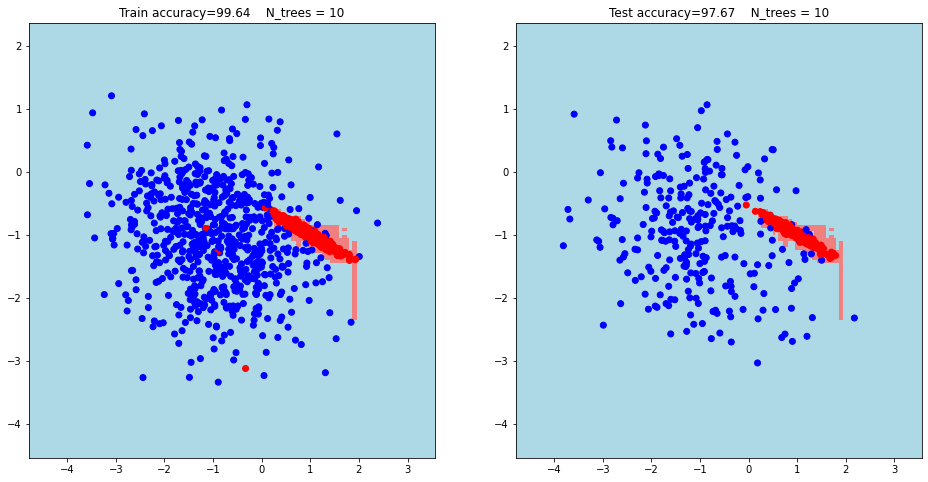

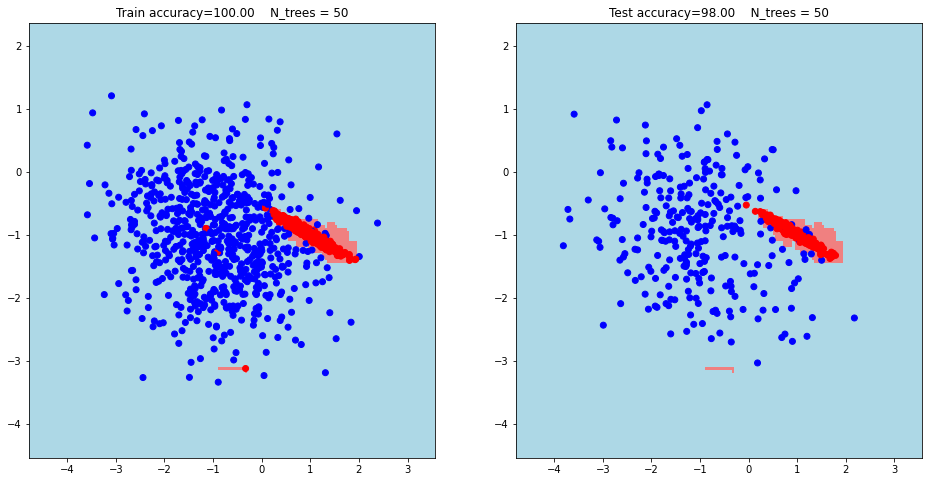

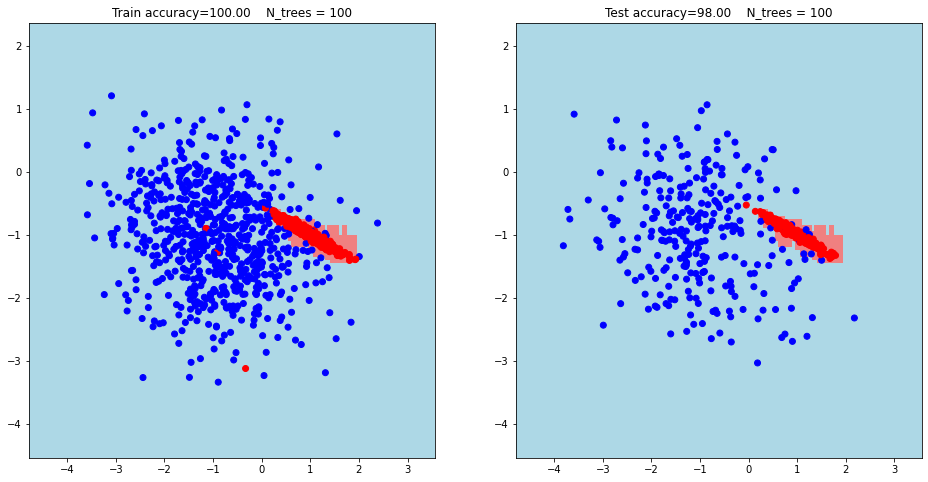

In [ ]:
n_trees = [1, 3, 10, 50]
for i in n_trees:
    forest(train_data, train_labels, n_trees = i)

In [ ]:
# forest(train_data, train_labels, n_trees = 1)

2. Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем



Сложность гиперплоскости при увеличении количества деревьев уменьшается.
При малом количестве деревьев происходит переобучение модели случайного леса.

3. Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.




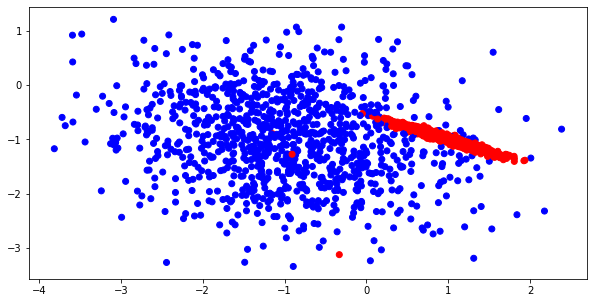

In [ ]:
# сгенерируем данные
classification_data, classification_labels = datasets.make_classification(n_samples=2000,
                                                      n_features = 2, n_informative = 2,
                                                      n_classes = 2, n_redundant=0,
                                                      n_clusters_per_class=1, random_state=23)
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(10,5))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)),
              c=classification_labels, cmap=colors)

In [ ]:
# Тут дополнительно к бутстрап выборке определяется список объектов и соответствующих деревьях на которых эти объекты не будут обучаться
random.seed(42)

def get_bootstrap_oob(data, labels, N):

    n_samples = data.shape[0]
    bootstrap = []
    samples_oob = []

    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)

        index = [i for i in range(len(data))]
        index_history = []

        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            index_history.append(sample_index)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]

        index_history = np.unique(index_history, axis = 0)
        index[:] = [v for i,v in enumerate(index) if i not in index_history]

        bootstrap.append((b_data, b_labels))
        samples_oob.append(index)
        subsample = get_subsample_oob(samples_oob, n_samples)

    return bootstrap, subsample


# поиск списков индексов деревьев, на которых не обучались объекты
def get_subsample_oob(samples_oob, N):
    err = []
    X = []

    for i in range(N):
        Xi = []
        for j in range(len(samples_oob)):
            try:
                samples_oob[j].index(i)
                Xi.append(j)
            except ValueError:
                err.append([j,i])
        X.append(Xi)
    return X


# предсказание по одному объекту Out-of-Bag леса, которое не обучено на этом объекте
def predict_oob(obj, forest, index_oob):
    classes = []
    predicts = 0

    for t_id in index_oob:
        prediction = classify_object(obj, forest[t_id])
        predicts += prediction

    if len(index_oob) == 0:
        return 0

    return int(round(predicts/len(index_oob)))


def oob_data_prepare(forest, data, list_index_oob):
    oob_predict = []
    oob_labels = []

    for i in range(len(list_index_oob)):
        oob_predict.append(predict_oob(data[i], forest, list_index_oob[i]))

    return oob_predict


def random_forest_oob(data, labels, n_trees):
    forest = []
    bootstrap, index = get_bootstrap_oob(data, labels, n_trees)

    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))

    return forest, index


def forest_oob(data, labels, n_trees):
    my_forest,  samples_oob = random_forest_oob(data, labels, n_trees)

    # Oтветы для обучающей выборки
    train_answers = tree_vote(my_forest, data)

    # Oтветы для Out-of-Bag выборки и саму Out-of-Bag выборку
    predict_oob = oob_data_prepare(my_forest, data, samples_oob)

    # Точность на обучающей выборке
    train_accuracy = accuracy_metric(labels, train_answers)

    # Точность на Out-of-Bag выборке
    test_accuracy = accuracy_metric(labels, predict_oob)

    # График
    plot_forest(my_forest, data, labels, train_accuracy, test_accuracy)

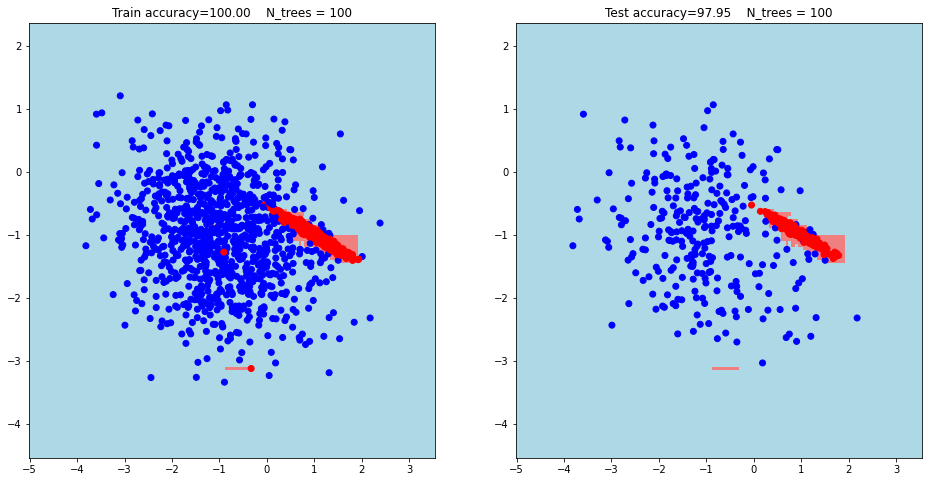

In [ ]:
forest_oob(classification_data, classification_labels, n_trees=50)

4. (На повторение) Переписать функцию gini из урока про решающие деревья так, чтобы в качестве критерия использовалась энтропия Шэннона. Переименовать функцию в entropy и сравнить результаты построения леса по Шеннону и Gini.


---



In [ ]:
def entropy(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1

    #  расчет критерия
    ent = 0
    for label in classes:
        p = classes[label] / len(labels)
        ent -= p * np.log2(p)

    return ent

entropy(classification_labels)


0.9999971146079947